Vamos começar com a análise exploratória do dataset Favorita(a famosa EDA - Exploratory Data Analysis). 

Este notebook vai conter:

Dados Utilizados (do Kaggle)

    - train.csv -- vendas por loja/produto/dia
    - stores.csv -- dados das lojas
    - items.csv -- dados dos produtos
    - oil.csv -- preço do petróleo(usado como variável macroeconômica)
    - holidays_events.csv -- feriados e eventos
    - transactions -- número de transações por loja/dia
    - test.csc -- dados para prever

Objetivos da EDA:

    1. Carregar os dados corretamente
    2. Unir tabelas relevantes (train, stores, items, holidays)
    3. Verificar distribuição de vendas, sazonalidade, feriados
    4. Criar uma coluna de estoque simulado
    5. Criar a variável-alvo: ruptura = 1 se estoque_simulado < vendas_previstas

Conceito Importante:

Como o dataset não tem uma coluna de "estoque" real, vamos simular isso, como se a loja tivesse um limite de estoque inicial diário. Essa simulação vai nos permitir gerar uma variável de ruptura para prever.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

Configurações Iniciais

In [2]:
pd.set_option('display.max_columns', 50)
sns.set_style('whitegrid')

In [5]:
#Caminho dos arquivos
DATA_PATH = '../data/'

Carregando os arquivos principais

In [11]:
df_train = pd.read_csv(os.path.join(DATA_PATH, "train.csv"), parse_dates=['date'])
df_stores = pd.read_csv(os.path.join(DATA_PATH, 'stores.csv'))
df_holidays = pd.read_csv(os.path.join(DATA_PATH, 'holidays_events.csv'), parse_dates=['date'])
df_transactions = pd.read_csv(os.path.join(DATA_PATH, 'transactions.csv'), parse_dates=['date'])

Visualização inicial

In [16]:
print("Train:")
df_train.head()

Train:


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [15]:
print("\nStores:")
df_stores.head()


Stores:


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [14]:
print("\nHolidays:")
df_holidays.head()



Holidays:


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [17]:
print("\nTransactions")
df_transactions.head()


Transactions


,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


Merge dos dados

In [18]:
df = df_train.merge(df_stores, on="store_nbr", how='left')
df = df.merge(df_transactions, on=['store_nbr', 'date'], how='left')
df = df.merge(df_holidays[['date', 'locale_name', 'type']], on='date', how='left')

Criando columa binária de feriado

In [23]:
df['is_holiday'] = df['type_x'].notnull().astype(int)
df.drop(columns=['type_x'], inplace=True)

Simular estoque fictício por item-loja-dia

In [29]:
df['estoque_simulado'] = 50 # valor fixo
df['ruptura'] = (df['sales'] > df['estoque_simulado']).astype(int)

Análise Descritiva

In [30]:
print("\nResumo estatístico das vendas:")
print(df['sales'].describe())


Resumo estatístico das vendas:
count    3.054348e+06
mean     3.590209e+02
std      1.107286e+03
min      0.000000e+00
25%      0.000000e+00
50%      1.100000e+01
75%      1.960110e+02
max      1.247170e+05
Name: sales, dtype: float64


Gráfico de distribuição de vendas

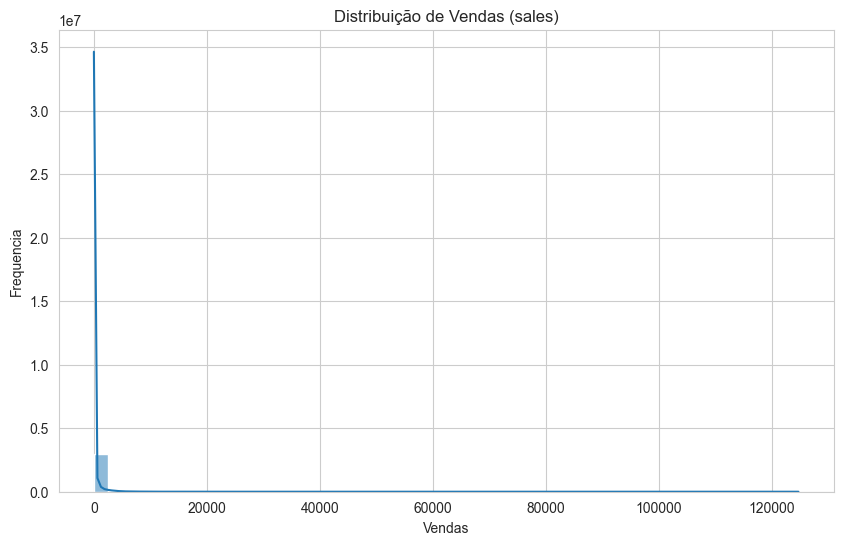

In [31]:
plt.figure(figsize=(10, 6))
sns.histplot(df['sales'], bins=50, kde=True)
plt.title("Distribuição de Vendas (sales)")
plt.xlabel("Vendas")
plt.ylabel("Frequencia")
plt.show()

Taxa de ruptura simulada

In [32]:
ruptura_pct = df['ruptura'].mean() * 100
print(f"\nTaxa de ruptura simulada: {ruptura_pct:.2f}%")


Taxa de ruptura simulada: 37.62%


Salvar dataset processado

In [33]:
df.to_csv(os.path.join(DATA_PATH, "favorita_com_ruptura.csv"), index=False)